# Homogeneous Graph Analysis: Cora Data Set

The Cora dataset represents a citation network, where nodes represent scientific papers and edges represent citations between papers. 

In this example, we'll create a simple Graph Convolutional Network (GCN) and a Graph Sage Network Model. 
To learn more about these layers visit this [link](https://www.youtube.com/watch?v=247Mkqj_wRM&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=21)

The Pytorch Geometric Project has as a fantastic list of curated videos and colab notebooks for the interested reader, which 
can be found [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)

<p align="left">
  <img src="https://graphsandnetworks.com/wp-content/uploads/2019/09/CoraBalloons.png" width=400 height=250/>
</p>



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as trans
import torch as T
import torch.nn.functional as F
import seaborn as sns
import warnings

from sklearn.manifold import TSNE
from pathlib import Path
from IPython.display import display
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from IPython.display import Javascript  # Restrict height of output cell.
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx

!curl https://temprl.com/nodes.csv -C - --output ./data/cora_nodes.csv
!curl https://temprl.com/edges.csv -C - --output ./data/cora_edges.csv;

Firstly, we'll create some helper functions for visualizations later


In [2]:
%matplotlib inline
# Helper function for visualization.
def visualize(h, datapipeline):
    """
    Visualizes the embeddings using t-SNE and scatter plot.

    Parameters:
    - h (torch.Tensor): Embeddings to visualize.
    - color (torch.Tensor): Labels for coloring the scatter plot.

    Returns:
    None
    """
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    y_map_rev = {k: v for v, k in datapipeline.y_map.items()}
    y_vals = datapipeline.data.y.detach().cpu().numpy()
    y_vals = [y_map_rev[y] for y in y_vals]
    g = sns.scatterplot(x=z[:,0],y=z[:,1],hue=y_vals ,palette=sns.color_palette("hls",10), legend="full")
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def draw_graph(data):
    """
    Draw a graph visualization using networkx and matplotlib.

    Parameters:
    - data (torch_geometric.data.Data): Graph data.

    Returns:
    None
    """
    warnings.filterwarnings("ignore")
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, seed=42)
    cent = nx.degree_centrality(G)
    node_size = list(map(lambda x: x * 500, cent.values()))
    cent_array = np.array(list(cent.values()))
    threshold = sorted(cent_array, reverse=True)[10]

    cent_bin = np.where(cent_array >= threshold, 1, 0.1)
    plt.figure(figsize=(7, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                cmap=plt.cm.plasma,
                                node_color=cent_bin,
                                nodelist=list(cent.keys()),
                                alpha=cent_bin)
    edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
    plt.show()

Here a simple class is created to process the data. 

Here, we create a Pytorch Geometric Data Object (called "data" below). This is simply:

- feature tensor of size (nodes, features): data.x
- edge indices tensor of size (2, edges): data.edge_label
- edge labels tensor of size (nodes):data.y

N.B.: The node labels must be mapped to 0:num_nodes for PyG compatability. Then the same map must be applied to the edges. 

It's also worth paying attention to how the train-val-test splitting is done. 
As this is a node classification task we'll use [RandomNodeSplit](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomNodeSplit.html). 
For link prediction check out [RandomLinkSplit](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html#torch_geometric.transforms.RandomLinkSplit).



/var/folders/zq/wqqn8n8560g60_9fjfw4lddm0000gq/T/ipykernel_83414/105961613.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges = edges_raw.astype('int').applymap(self.node_map.get)


----------------------
Graph Data Statistics
---------------------
Number of nodes_raw: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True 
----------------------


NETWORK GRAPH:



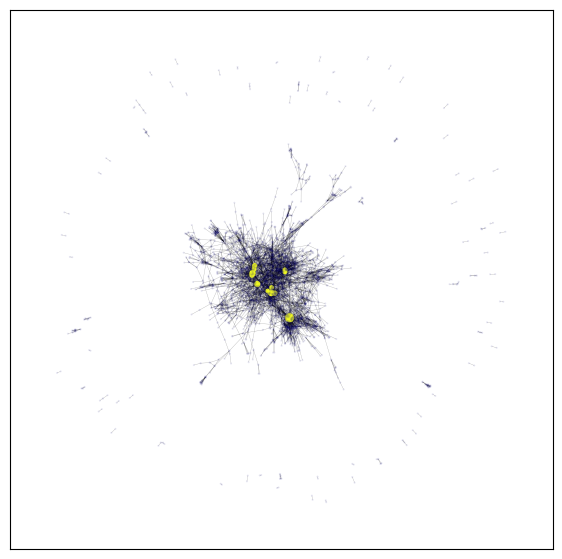

In [3]:
class ProcessData:
    """Class for processing graph data and returning train, validation, and test sets in PyTorch Geometric format.
        Parameters:
        - None

        Methods:
        - stats(): Gather statistics about the graph.
        - split(): Split the graph data into train, validation, and test sets.
        - draw_graph(): Draw a network graph visualization.
        - run(): Execute the data processing pipeline.

        Returns:
        - data (torch_geometric.data.Data): Processed graph data.
        - train_data (torch_geometric.data.Data): Train set.
        - val_data (torch_geometric.data.Data): Validation set.
        - test_data (torch_geometric.data.Data): Test set.
    """

    def __init__(self):
        nodes_raw = pd.read_csv(Path('./data/cora_nodes.csv'))
        edges_raw = pd.read_csv(Path('./data/cora_edges.csv'), usecols=['sourceNodeId', 'targetNodeId'])

        self.node_map = {v: k for k, v in nodes_raw['nodeId'].to_dict().items()}


        # Create the edges dataframe.
        edges = edges_raw.astype('int').applymap(self.node_map.get)
        edges = np.transpose(edges[['sourceNodeId', 'targetNodeId']].to_numpy())

        # Create the node features dataframe.
        features = (nodes_raw[['nodeId', 'features']].copy()
                .assign(nodeId_mapped = nodes_raw['nodeId'].map(self.node_map))
                .assign(features = nodes_raw.features.str.replace('[', '')
                        .str.replace(']', '')
                        .str.replace(" ", ""))
                )
        x =  features.features.str.split(",", expand=True).astype('int').to_numpy()
        self.feature_count = [len(i) for i in nodes_raw['features']]

        # Create the labels dataframe.
        self.y_map = {v: k for k, v in nodes_raw.subject.drop_duplicates().reset_index(drop=True).to_dict().items()}
        y = nodes_raw['subject'].map(self.y_map).to_numpy()

        # Create the PyTorch Geometric Data object.
        self.data = Data(x = T.from_numpy(x).to(T.float), edge_index = T.from_numpy(edges), y  = T.from_numpy(y))

        assert max(self.feature_count) == min(self.feature_count)

    def stats(self):
        ''' Print key statistics about the graph.
            Parameters:
            - None

            Returns:
            - None

        '''
        # Gather some statistics about the graph.

        print ('----------------------')
        print ('Graph Data Statistics')
        print  ('---------------------')

        print(f'Number of nodes_raw: {self.data.num_nodes}')
        print(f'Number of edges: {self.data.num_edges}')
        print(f'Average node degree: {self.data.num_edges / self.data.num_nodes:.2f}')

        print(f'Has isolated nodes: {self.data.has_isolated_nodes()}')
        print(f'Has self-loops: {self.data.has_self_loops()}')
        print(f'Is undirected: {self.data.is_undirected()} ')
        print  ('----------------------\n')

    def split(self):
        """Split the graph data into train, validation, and test sets.
            Parameters:
            - None

            Returns:
            - None
        """
        self.data = trans.RandomNodeSplit()(self.data)

        # print(f'Trainset: {self.train_data}')
        # print(f'Valset: {self.val_data}')
        # print(f'Testset: {self.test_data}\n')



    def draw_graph(self):
        """Draw a network graph visualization.
            Parameters:
            - None

            Returns:
            - None
        """
        print(f'\nNETWORK GRAPH:\n')
        draw_graph(self.data)

    def run(self):
        """Execute the data processing pipeline.
            Parameters:
            - None

            Returns:
            - data (torch_geometric.data.Data): Processed graph data.
            - train_data (torch_geometric.data.Data): Train set.
            - val_data (torch_geometric.data.Data): Validation set.
            - test_data (torch_geometric.data.Data): Test set.
        """
        self.stats()
        self.split()
        self.draw_graph()
        return self.data

datapipeline = ProcessData()
data= datapipeline.run()



In [4]:
class GCN(T.nn.Module):
    """Graph Convolutional Network (GCN) model."""
    def __init__(self, hidden_channels):
        super().__init__()
        T.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,7)

    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GSN(T.nn.Module):
    """Graph Sage Network (GSN) model."""
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, 7)

    def forward(self, data):

        # print (x)
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define the model TYPES
conv_model = GCN(hidden_channels=16)
sage_model = GSN(hidden_channels=16)

print (conv_model)
print ('----------------------')
print (sage_model)
print ('----------------------')

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
----------------------
GSN(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)
----------------------


-----------------------------------------
RUNNING GRAPH CONVOLUTIONAL NETWORK MODEL
-----------------------------------------
Epoch: 001, Loss: 1.9508,  val_loss: 1.9492
Epoch: 010, Loss: 0.9949,  val_loss: 1.0300
Epoch: 020, Loss: 0.5593,  val_loss: 0.5634
Epoch: 030, Loss: 0.3834,  val_loss: 0.4290
Epoch: 040, Loss: 0.3155,  val_loss: 0.3874
Epoch: 050, Loss: 0.2937,  val_loss: 0.3738
Epoch: 060, Loss: 0.2568,  val_loss: 0.3730
Epoch: 070, Loss: 0.2380,  val_loss: 0.3674
Epoch: 080, Loss: 0.2223,  val_loss: 0.3689
Epoch: 090, Loss: 0.2137,  val_loss: 0.3746

----------->Test Accuracy: 0.8740

TSNE Visualization of Embeddings:


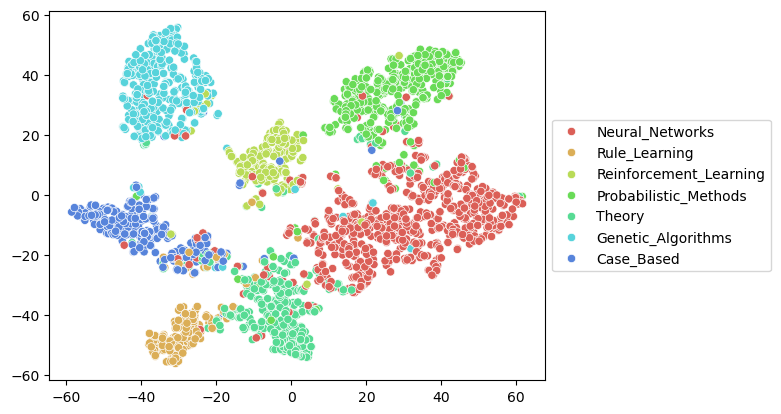

--------------------------------
RUNNING GRAPH SAGE NETWORK MODEL
--------------------------------
Epoch: 001, Loss: 2.0016,  val_loss: 1.9787
Epoch: 010, Loss: 0.7369,  val_loss: 0.8033
Epoch: 020, Loss: 0.3833,  val_loss: 0.4813
Epoch: 030, Loss: 0.2668,  val_loss: 0.4050
Epoch: 040, Loss: 0.2143,  val_loss: 0.3824
Epoch: 050, Loss: 0.1731,  val_loss: 0.3818
Epoch: 060, Loss: 0.1514,  val_loss: 0.3899
Epoch: 070, Loss: 0.1391,  val_loss: 0.3931
Epoch: 080, Loss: 0.1222,  val_loss: 0.4058
Epoch: 090, Loss: 0.1105,  val_loss: 0.4108

----------->Test Accuracy: 0.8640

TSNE Visualization of Embeddings:


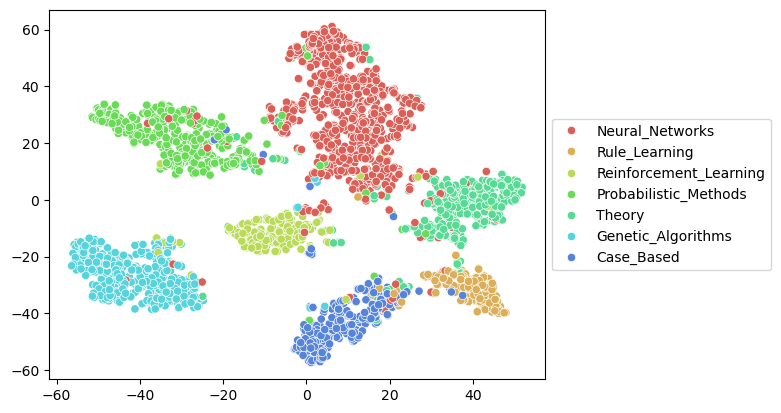

In [5]:
criterion = T.nn.CrossEntropyLoss()

def train(model):
      """Training Loop
      Parameters:
      - model (torch.nn.Module): Model to train.

      Returns:
      - loss (float): Training loss.
      - val_loss (float): Validation loss.
      """
      optimizer = T.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.

      with T.no_grad():
            model.eval()
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
            pred = out.argmax(dim=1)
            val_correct = pred[data.val_mask] == data.y[data.val_mask]
            val_acc = int(val_correct.sum()) / int(len(data.y[data.val_mask]))

      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, val_loss

def test(model):
      """Testing Function
      Parameters:
      - model (torch.nn.Module): Model to test.

      Returns:
      - test_acc (float): Testing accuracy.
      """
      #Testing Mode
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask] # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(len(data.y[data.test_mask])) # Derive ratio of correct predictions.
      return test_acc

for model in [conv_model, sage_model]:
      if model == conv_model:
            print ('-----------------------------------------')
            print ('RUNNING GRAPH CONVOLUTIONAL NETWORK MODEL')
            print ('-----------------------------------------')
      elif model == sage_model:
            print ('--------------------------------')
            print ('RUNNING GRAPH SAGE NETWORK MODEL')
            print ('--------------------------------')
      for epoch in range(1, 100):
            loss, val_loss = train(model)
            if epoch % 10 == 0 or epoch == 1:
                  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f},  val_loss: {val_loss:.4f}')

      model.eval()
      out = model(data)


      test_acc = test(model)
      print(f'\n----------->Test Accuracy: {test_acc:.4f}\n')
      print(f'TSNE Visualization of Embeddings:')
      visualize(out, datapipeline)